# Imports

In [1]:
import numpy as np
import pandas as pd
import pkg_resources
import itertools
import shap
import math
import multiprocessing
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

from xgboostlss.model import *
from xgboostlss.distributions.Gaussian import Gaussian
from xgboostlss.datasets.data_loader import load_simulated_data

# Data

In [2]:
# The data is a simulated Gaussian as follows, where x is the only true feature and all others are noise variables
    # loc = 10
    # scale = 1 + 4*((0.3 < x) & (x < 0.5)) + 2*(x > 0.7)

train, test = load_simulated_data()
n_cpu = multiprocessing.cpu_count()

X_train, y_train = train.iloc[:,1:],train.iloc[:,0]
X_test, y_test = test.iloc[:,1:],test.iloc[:,0]

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Distribution and Quantile Selection

In [3]:
distribution = Gaussian                   # Estimates both location and scale parameters of the Gaussian simultaneously.
distribution.stabilize = "None"           # Option to stabilize Gradient/Hessian. Options are "None", "MAD", "L2"
quant_sel = [0.05, 0.95]

# Hyper-Parameter Optimization

In [4]:
np.random.seed(123)

# Specifies the parameters and their value range. The structure is as follows: "hyper-parameter": [lower_bound, upper_bound]. Currently, only the following hyper-parameters can be optimized:
params = {"eta": [1e-5, 1],                   
          "max_depth": [1, 10],
          "gamma": [1e-8, 40],
          "subsample": [0.2, 1.0],
          "colsample_bytree": [0.2, 1.0],
          "min_child_weight": [0, 500]
         }

opt_params = xgboostlss.hyper_opt(params,
                                  dtrain=dtrain,
                                  dist=distribution,
                                  num_boost_round=500,       # Number of boosting iterations.
                                  max_minutes=120,           # Time budget in minutes, i.e., stop study after the given number of minutes.
                                  n_trials=None,             # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                                  silence=False)             # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.

[I 2021-12-19 12:26:11,136] A new study created in memory with name: XGBoostLSS-HyperOpt
C:\Users\Alexander\.julia\v0.6\Conda\deps\usr\envs\xgboostlss\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


0it [00:00, ?it/s]

[I 2021-12-19 12:28:47,298] Trial 0 finished with value: 1469.9499782 and parameters: {'eta': 0.030363087280807707, 'max_depth': 3, 'gamma': 1.5074442732613943e-06, 'subsample': 0.4857160809399238, 'colsample_bytree': 0.6366741608938994, 'min_child_weight': 211}. Best is trial 0 with value: 1469.9499782.
[I 2021-12-19 12:29:05,441] Trial 1 finished with value: 1725.4302014999998 and parameters: {'eta': 0.8013476947482925, 'max_depth': 7, 'gamma': 0.0004148938237251032, 'subsample': 0.3759312069680463, 'colsample_bytree': 0.3474570556327573, 'min_child_weight': 365}. Best is trial 0 with value: 1469.9499782.
[I 2021-12-19 12:31:40,162] Trial 2 finished with value: 1710.6239478 and parameters: {'eta': 0.0015590542353378792, 'max_depth': 1, 'gamma': 6.638115717563432e-05, 'subsample': 0.6559438243964698, 'colsample_bytree': 0.26827872970098154, 'min_child_weight': 87}. Best is trial 0 with value: 1469.9499782.
[I 2021-12-19 12:34:16,865] Trial 3 finished with value: 1600.5797027999997 and

# Model Training

In [5]:
np.random.seed(123)

n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyper-parameters
xgboostlss_model = xgboostlss.train(opt_params,
                                    dtrain,
                                    dist=distribution,
                                    num_boost_round=n_rounds)

# Prediction

In [6]:
# Number of samples to draw from predicted distribution
n_samples=10000

# Using predicted distributional parameters, sample from distribution
pred_y = xgboostlss.predict(xgboostlss_model, 
                            dtest, 
                            dist=distribution,
                            pred_type="response",
                            n_samples=n_samples, 
                            seed=123)

# Using predicted distributional parameters, calculate quantiles
pred_quantiles = xgboostlss.predict(xgboostlss_model, 
                                    dtest, 
                                    dist=distribution,
                                    pred_type="quantiles", 
                                    quantiles=quant_sel, 
                                    seed=123)


# Returns predicted distributional parameters
pred_params = xgboostlss.predict(xgboostlss_model, 
                                 dtest, 
                                 dist=distribution,
                                 pred_type="parameters")

In [7]:
pred_y.head()

,y_pred_sample_0,y_pred_sample_1,y_pred_sample_2,y_pred_sample_3,y_pred_sample_4,y_pred_sample_5,y_pred_sample_6,y_pred_sample_7,y_pred_sample_8,y_pred_sample_9,...,y_pred_sample_9990,y_pred_sample_9991,y_pred_sample_9992,y_pred_sample_9993,y_pred_sample_9994,y_pred_sample_9995,y_pred_sample_9996,y_pred_sample_9997,y_pred_sample_9998,y_pred_sample_9999
0,6.865299,12.893433,10.826054,5.647897,8.332645,14.786373,2.984303,8.765841,13.670735,7.498767,...,6.937333,6.288096,13.107327,15.537355,11.885817,8.276741,5.961499,8.640375,11.691320,12.816069
1,6.865299,12.893433,10.826054,5.647897,8.332645,14.786373,2.984303,8.765841,13.670735,7.498767,...,6.937333,6.288096,13.107327,15.537355,11.885817,8.276741,5.961499,8.640375,11.691320,12.816069
2,8.897316,11.026662,10.296392,8.467287,9.415634,11.695314,7.526414,9.568654,11.301232,9.121079,...,8.922761,8.693428,11.102217,11.960587,10.670737,9.395886,8.578063,9.524335,10.602034,10.999334
3,4.932317,14.669222,11.329902,2.965915,7.302438,17.726781,-1.336437,8.002155,15.924754,5.955522,...,5.048670,3.999993,15.014713,18.939801,13.041677,7.212139,3.472460,7.799497,12.727516,14.544260
4,6.865299,12.893433,10.826054,5.647897,8.332645,14.786373,2.984303,8.765841,13.670735,7.498767,...,6.937333,6.288096,13.107327,15.537355,11.885817,8.276741,5.961499,8.640375,11.691320,12.816069


In [8]:
pred_quantiles.head()

,y_quant_0.05,y_quant_0.95
0,5.246907,14.767322
1,5.246907,14.767322
2,8.325644,11.688585
3,2.318219,17.696009
4,5.246907,14.767322


In [9]:
pred_params.head()

,location,scale
0,10.007114,2.894001
1,10.007114,2.894001
2,10.007114,1.022261
3,10.007114,4.674516
4,10.007114,2.894001


# SHAP Interpretability

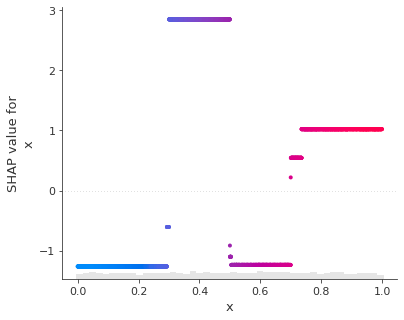

In [10]:
# Partial Dependence Plot of how x acts on variance 
xgboostlss.plot(xgboostlss_model, 
                X_test, 
                parameter="scale",
                feature="x", 
                plot_type="Partial_Dependence")

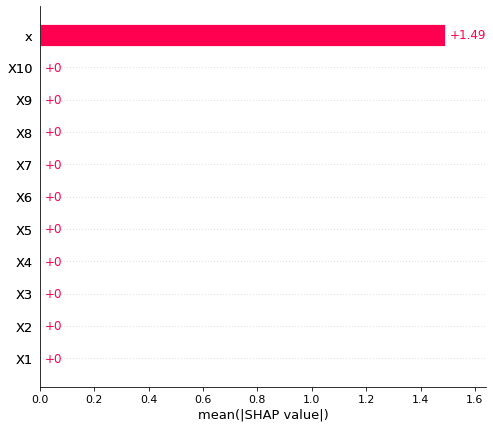

In [11]:
# Feature Importance of features on scale parameter
xgboostlss.plot(xgboostlss_model, 
                X_test, 
                parameter="scale", 
                plot_type="Feature_Importance")

# Plot of Actual vs. Predicted Quantiles

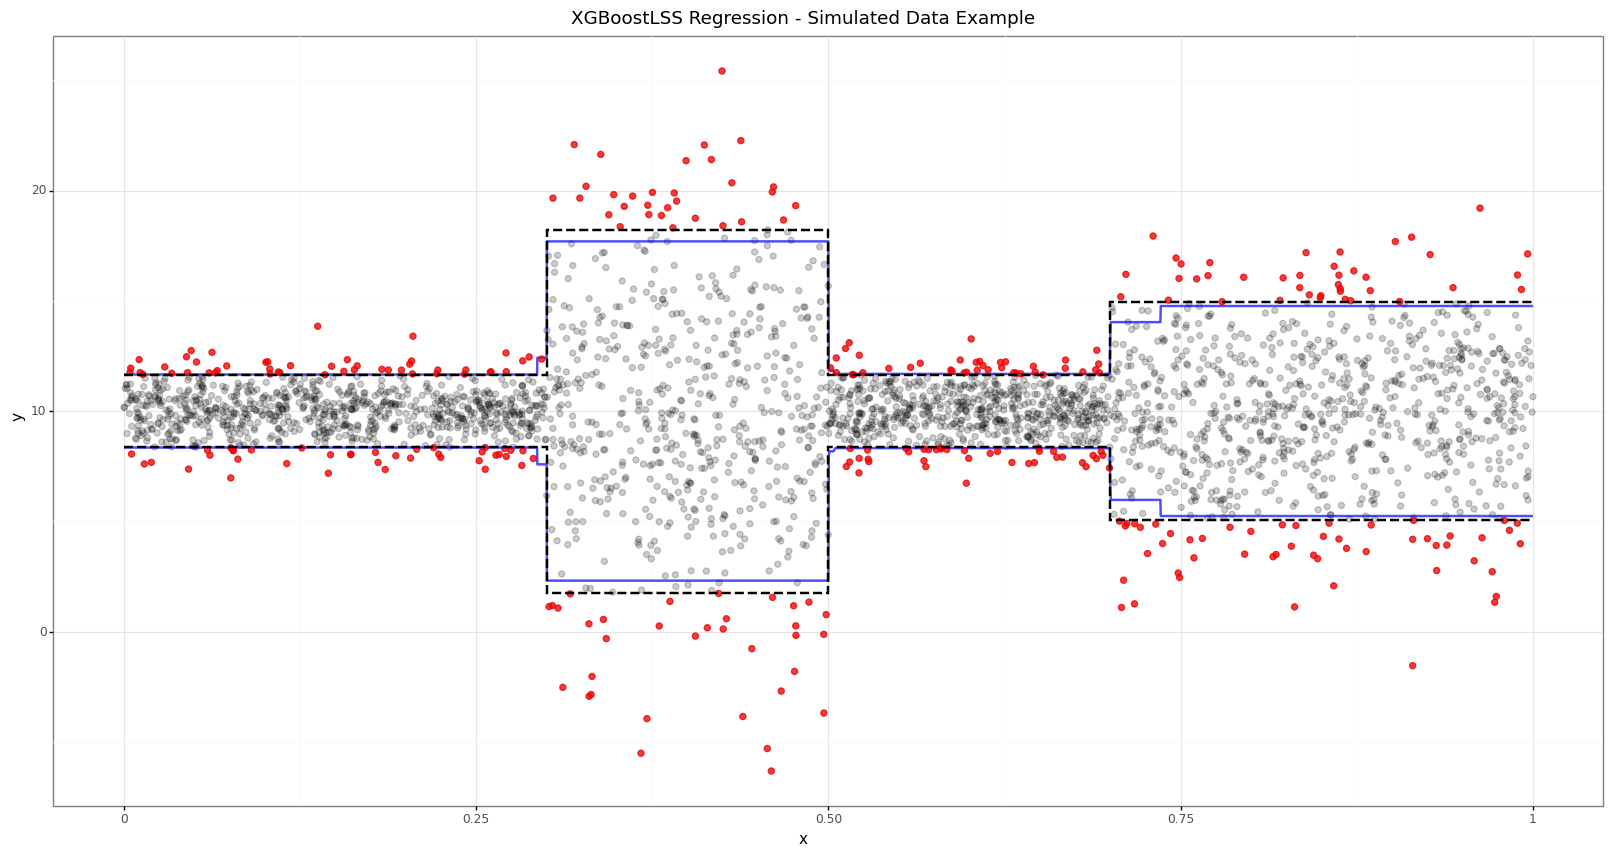

<ggplot: (145224970998)>

In [12]:
np.random.seed(123)

###
# Actual Quantiles
###
q1 = norm.ppf(quant_sel[0], loc = 10, scale = 1 + 4*((0.3 < test["x"].values) & (test["x"].values < 0.5)) + 2*(test["x"].values > 0.7))
q2 = norm.ppf(quant_sel[1], loc = 10, scale = 1 + 4*((0.3 < test["x"].values) & (test["x"].values < 0.5)) + 2*(test["x"].values > 0.7))
test["quant"] = np.where(test["y"].values < q1, 0, np.where(test["y"].values < q2, 1, 2))
test["alpha"] = np.where(test["y"].values <= q1, 1, np.where(test["y"].values >= q2, 1, 0))
df_quantiles = test[test["alpha"] == 1]

# Lower Bound
yl = list(set(q1))
yl.sort()
yl = [yl[2],yl[0],yl[2],yl[1],yl[1]]
sfunl = pd.DataFrame({"x":[0, 0.3, 0.5, 0.7, 1],
                      "y":yl})

# Upper Bound
yu = list(set(q2))
yu.sort()
yu = [yu[0],yu[2],yu[0],yu[1],yu[1]]
sfunu = pd.DataFrame({"x":[0, 0.3, 0.5, 0.7, 1],
                      "y":yu})



###
# Forecasted Quantiles
###
test["lb"] = pred_quantiles.iloc[:,0]
test["ub"] = pred_quantiles.iloc[:,1]



###
# Plot
###
(ggplot(test,
        aes("x",
            "y")) + 
 geom_point(alpha = 0.2, color = "black", size = 2) + 
 theme_bw() + 
 theme(legend_position="none",
       plot_title = element_text(hjust = 0.5)) +
 labs(title = "XGBoostLSS Regression - Simulated Data Example")  + 
 geom_line(aes("x",
               "ub"),
           size = 1,
           color = "blue", 
           alpha = 0.7) + 
 geom_line(aes("x",
               "lb"),
           size = 1,
           color = "blue", 
           alpha = 0.7) + 
 geom_point(df_quantiles,
            aes("x",
                "y"), 
            color = "red", 
            alpha = 0.7,
            size = 2) + 
 geom_step(sfunl,
           aes("x",
               "y"), 
           size = 1, 
           linetype = "dashed")  + 
 geom_step(sfunu,
           aes("x",
               "y"), 
           size = 1, 
           linetype = "dashed") 
)